In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from math import *
matplotlib.rcParams['figure.figsize'] = (14, 6)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
matplotlib.rcParams['font.weight'] = 'normal'

In [2]:
# import the data
trial = "10-Push"
fileName = "Gravel_10Push_1"
surface = "Gravel"
rlData = pd.read_csv("./src/" + fileName + "_RL_Redo.CSV")
sensor_distance = 0.203
wheel_radius = 0.308

In [3]:
# define a kalman filter function
def kalman(x, x0, p, q, r):
    # calculate the current gain
    k = (p + q) / (p + q + r);
    # update the prediction
    p = r * (p + q) / (p + q + r);
    # update the result
    y = x0 + (x - x0) * k;
    
    # return!
    yield y
    yield p

In [4]:
# Get our relevant data out of the two datasets
t = rlData['Timestamp']
ax = rlData['A_x']
bx = rlData['B_x']

In [5]:
max_capacity = 4.5
min_push_time = 0.2
# initialize some useful variables
lastVelocity = sqrt(abs(bx[0] - ax[0]) / sensor_distance)
lastAcceleration = 0
activeThreshold = 0.1 * max_capacity
isPushing = False
pushStartTime = 0
isRedlining = False
velocityRMS = []
decelerationRMS = []
deceleration = 0
redline_capacity = 0.8 * max_capacity

In [6]:
# keep track of some things for plotting
velocityTrace = np.zeros(len(t))
velocityTrace[0] = lastVelocity
accelerationTrace = np.zeros(len(t))
pushStartIndex = 1
pushTrace = np.zeros(len(t))
redlineTrace = np.zeros(len(t))
decelerationTrace = np.zeros(len(t))

In [7]:
a = ax[0]
p_a = 1
b = bx[0]
p_b = 1
p_velocity = 1
p_acceleration = 1

# loop!
for i in range(1,len(t)):
    a, p_a = kalman(ax[i], a, p_a, 0.0001, 0.01)
    b, p_b = kalman(bx[i], b, p_b, 0.0001, 0.01)
    
    dx = b - a
    dx = dx - 0.0546
    
    if dx < 0:
        dx = 0
    
    dt = t[i] - t[i - 1]
    velocity = sqrt(dx / sensor_distance)
    velocity, p_velocity = kalman(velocity, lastVelocity, p_velocity, 0.0001, 0.01)
    
    acceleration = (velocity - lastVelocity) / dt
    acceleration, p_acceleration = kalman(acceleration, lastAcceleration, p_velocity, 0.0001, 0.01)
    accelerationTrace[i] = acceleration
    
    # update our old values
    lastVelocity = velocity
    lastAcceleration = acceleration
    
    # determine if we're above the minimum acceleration
    if acceleration >= activeThreshold:
        # determine if we're pushing
        if not isPushing:
            isPushing = True
            pushStartTime = t[i]
            pushStartIndex = i
            isRedlining = False
            if len(decelerationRMS) > 1:
                deceleration = sqrt(np.mean(np.square(decelerationRMS)))
            deceleration = []
        
        # determine if we're redlining
        #if ((acceleration + deceleration) >= redline_capacity) and not isRedlining and (t[i] - pushStartTime) >= min_push_time:
        if ((acceleration) >= redline_capacity) and not isRedlining and (t[i] - pushStartTime) >= min_push_time:
            isRedlining = True
    else:
        # not accelerating
        if isPushing:
            isPushing = False
            # check to see if the push was long enough to count as a push
            if (t[i] - pushStartTime) >= min_push_time:
                #pushes = pushes + 1;
                pushTrace[pushStartIndex:i] = np.max(accelerationTrace[pushStartIndex:i])
        
        # turn off redlining status
        if isRedlining:
            print("Was redlining from %f to %f" % (t[pushStartIndex], t[i]))
            isRedlining = False
            redlineTrace[pushStartIndex:i] = redline_capacity
        
        # keep track of deceleration
        if acceleration < -activeThreshold:
            decelerationRMS.append(acceleration)
    
    # pull things in the noise range to 0
    if dx < 0.075:
        velocity = 0
    
    velocityTrace[i] = velocity

Was redlining from 1.390018 to 2.571042


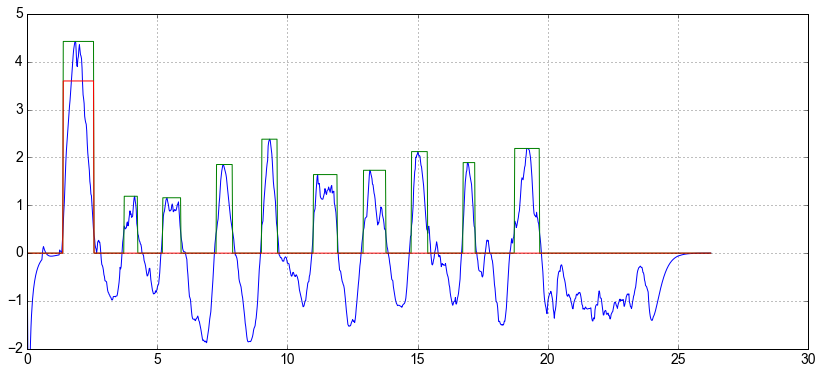

In [8]:
plt.plot(t, accelerationTrace)
plt.plot(t, pushTrace)
plt.plot(t, redlineTrace)
plt.grid(True)
plt.ylim((-2,5))
plt.show()

In [9]:
df = pd.DataFrame({
        "0t": t,
        "1p": pushTrace * (1.621887583781318 / np.max(accelerationTrace))
    })
df.to_csv('assets/gravel_10_pushes.dat', sep=' ', index=False)

In [11]:
df = pd.DataFrame({
        "0t": t,
        "1r": redlineTrace * (1.621887583781318 / np.max(accelerationTrace))
    })
df.to_csv('assets/gravel_10_redline.dat', sep=' ', index=False)